# Machine Learning in Python - Project 2

Due Friday, April 12th by 4 pm.

*Include contributors names in notebook metadata or here*

## Setup

*Install any packages here and load data*

In [46]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.model_selection import train_test_split

In [47]:
# Load data in easyshare.csv
d = pd.read_csv("freddiemac.csv")
d.head()

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,...,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,...,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,...,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,...,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,...,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0


# Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a professional body (e.g. FreddiMac company or similar company). If you use any additional data sources, you should introduce them here and discuss why they were included.*

*Briefly outline the approaches being used and the conclusions that you are able to draw.*

# Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling. Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.*

*You should also split your data into training and testing sets, ideally before you look to much into the features and relationships with the target*

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data. Specifically, this should be any code that you use to generate new columns in the data frame `d`. Feature engineering that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

*If you decide to extract additional features from the full data (easyshare_all.csv), describe these variables here.*

*All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.*

**Missing value analysis** 

There is $1$ missing value for `fico` (credit score);

$3468$ NA values for `flag_fthb` (binary, first time homebuyer);

$594$ null values for `cd_msa` (metropolitan statistical area), indicating $594$ mortgaged properties are either not in a Metropolitan Area or MSA status unknown;

$1$ NA for `cltv` (ombined loan-to-value, aka. rate of loan amount to total property value, e.g. $90\%$);

$1$ NA for `dti` (debt-to-income ratio), indicating $1$ impossible value of $>65\%$;

$1$ NA for `ltv` (loan-to-value);

$38$ missing values for `ppmt_pnlty`,

$5751$ missing values for `flag_sc`.

In [48]:
missing_values_count = d.isnull().sum()
missing_values_table = pd.DataFrame({'Missing Values': missing_values_count})

print("Table of Null Values in Each Variable:")
print(missing_values_table)

count_9 = d['flag_fthb'].astype(str).str.count('9').sum()
print("Number of NA (encoded as 9) in 'flag_fthb':", count_9)
count_999 = d['mi_pct'].astype(str).str.count('999').sum()
print("Number of NA (999) in 'mi_pct':", count_999)
count_99 = d['cnt_units'].astype(str).str.count('99').sum()
print("Number of no information (99) in 'cnt_units':", count_99)
c9 = d['occpy_sts'].astype(str).str.count('9').sum()
print("Number of no information (9) in 'occpy_sts':", c9)
c999 = d['cltv'].astype(str).str.count('999').sum()
print("Number of no information (999) in 'cltv':", c999)
c_999 = d['dti'].astype(str).str.count('999').sum()
print("Number of NA (999) in 'dti':", c_999)
co_999 = d['ltv'].astype(str).str.count('999').sum()
print("Number of NA (999) in 'ltv':", co_999)
co_9 = d['channel'].astype(str).str.count('9').sum()
print("Number of NA (9) in 'channel':", co_9)
co_99 = d['prop_type'].astype(str).str.count('99').sum()
print("Number of NA (99) in 'prop_type':", co_99)
c_00 = d['zipcode'].astype(str).str.count('###00').sum()
print("Number of NA in 'zipcode':", c_00)
cou_9 = d['loan_purpose'].astype(str).str.count('9').sum()
print("Number of NA in 'loan_purpose':", cou_9)

Table of Null Values in Each Variable:
                Missing Values
fico                         1
dt_first_pi                  0
flag_fthb                    0
dt_matr                      0
cd_msa                     594
mi_pct                       0
cnt_units                    0
occpy_sts                    0
cltv                         0
dti                          0
orig_upb                     0
ltv                          0
int_rt                       0
channel                      0
ppmt_pnlty                  38
prod_type                    0
st                           0
prop_type                    0
zipcode                      0
id_loan                      0
loan_purpose                 0
orig_loan_term               0
cnt_borr                     0
seller_name                  0
servicer_name                0
flag_sc                   5751
prepaid                      0
default                      0
Number of NA (encoded as 9) in 'flag_fthb': 3468
Number of NA 

In [49]:
X = d.drop(columns=['default'])
y = d['default']  # Response variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

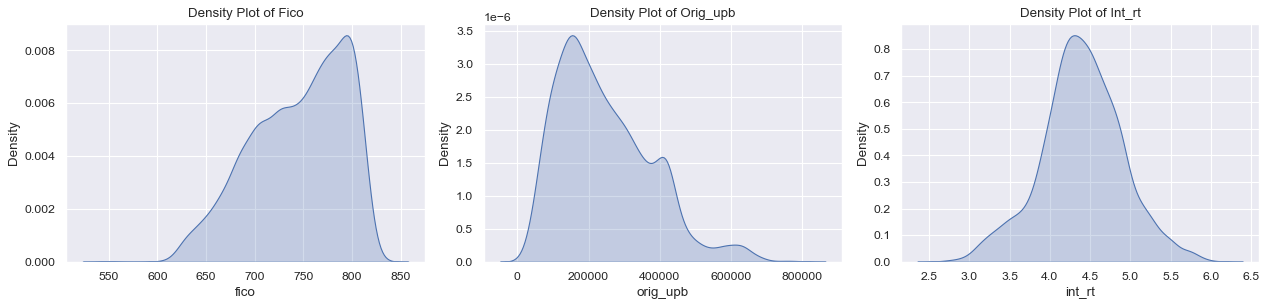

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
# Numerical variables
num_var = ['fico', 'orig_upb', 'int_rt']
for i, variable in enumerate(num_var):
    sns.kdeplot(data=X_train[variable], ax=axes[i], fill=True)
    axes[i].set_title(f'Density Plot of {variable.capitalize()}')

plt.tight_layout()
plt.show()

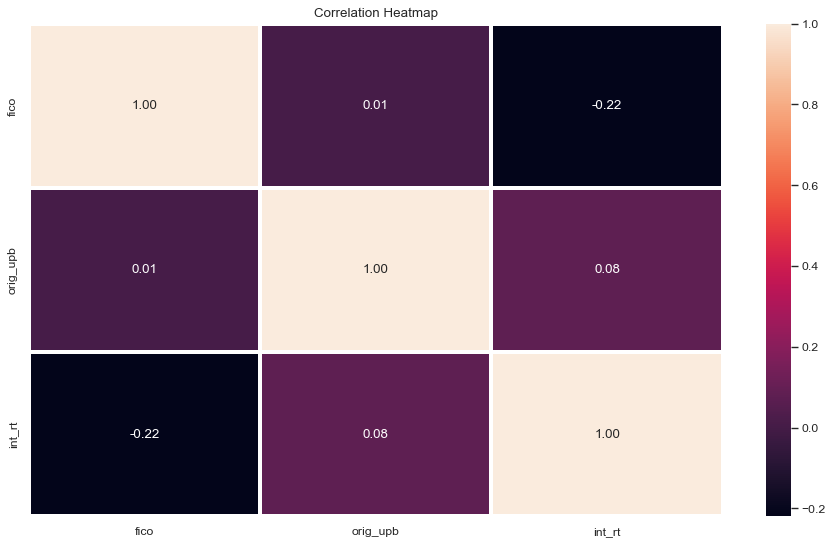

In [51]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.heatmap(X_train[num_var].corr(), annot = True, fmt = '.2f', linewidths = 2)
plt.title("Correlation Heatmap")
plt.show()

In [52]:
d

,fico,dt_first_pi,flag_fthb,dt_matr,cd_msa,mi_pct,cnt_units,occpy_sts,cltv,dti,...,zipcode,id_loan,loan_purpose,orig_loan_term,cnt_borr,seller_name,servicer_name,flag_sc,prepaid,default
0,709.0,201703,9,204702,NaN,12,1,P,84,26,...,51300,F117Q1000376,N,360,2,Other sellers,Other servicers,NaN,0,1
1,649.0,201703,9,203202,33124.0,0,1,P,52,22,...,33100,F117Q1000418,C,180,2,Other sellers,Other servicers,NaN,1,0
2,747.0,201703,9,203702,41180.0,0,1,I,43,20,...,63100,F117Q1000479,N,240,2,Other sellers,Other servicers,NaN,1,0
3,711.0,201703,9,204702,20260.0,0,1,I,80,21,...,55800,F117Q1000523,P,360,2,Other sellers,Other servicers,NaN,1,0
4,751.0,201703,N,204702,NaN,35,1,P,95,24,...,75900,F117Q1000719,P,360,1,Other sellers,ARVESTCENTRALMTGECO,NaN,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,725.0,201811,9,204810,41500.0,0,1,P,59,40,...,93900,F118Q3263412,C,360,2,"WELLSFARGOBANK,NA","WELLSFARGOBANK,NA",NaN,1,0
6100,768.0,201809,Y,204808,31084.0,0,1,P,79,46,...,90000,F118Q3263943,P,360,2,"STEARNSLENDING,LLC",Other servicers,Y,1,0
6101,752.0,201811,9,203310,39900.0,0,1,I,80,12,...,89400,F118Q3265340,P,180,2,Other sellers,Other servicers,NaN,1,0
6102,777.0,201811,N,204810,31084.0,0,1,P,80,48,...,93500,F118Q3267905,P,360,1,AMERIHOMEMTGECOMPANY,AMERIHOMEMTGECOMPANY,NaN,1,0


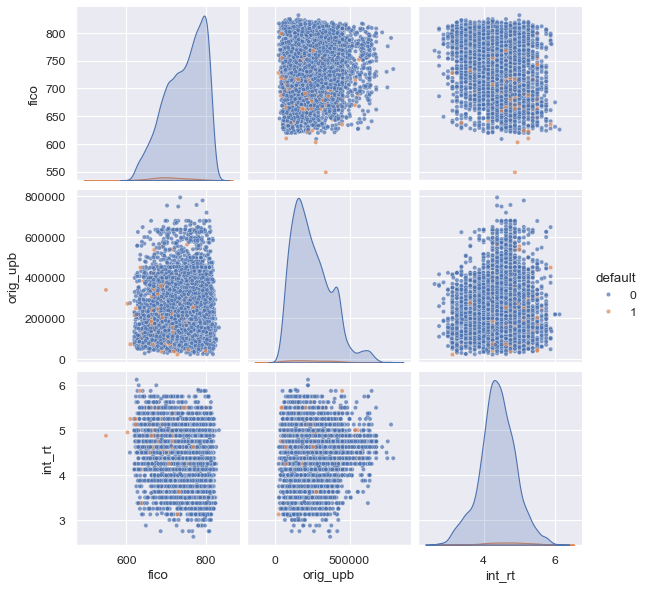

In [53]:
sns.pairplot(data=X_train, vars=num_var, hue="default", plot_kws={'alpha': 0.7, 's': 15})

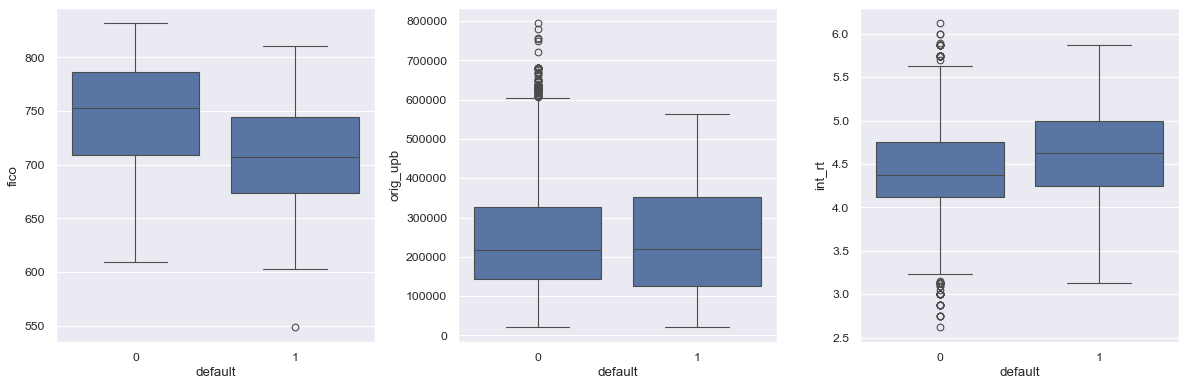

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Looping through the numerical variables and creating the boxplots
for i, var in enumerate(num_var):
    sns.boxplot(x=y_train, y=X_train[var], ax=axes[i])

# Displaying the plot
plt.tight_layout()
plt.show()

In [55]:
# set na
for column in d[num_var].columns:
    Q1 = d[num_var][column].quantile(0.25)
    Q3 = d[num_var][column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    d[column] = d[num_var][column].mask((d[num_var][column] < lower_bound) | (d[num_var][column] > upper_bound), np.nan)

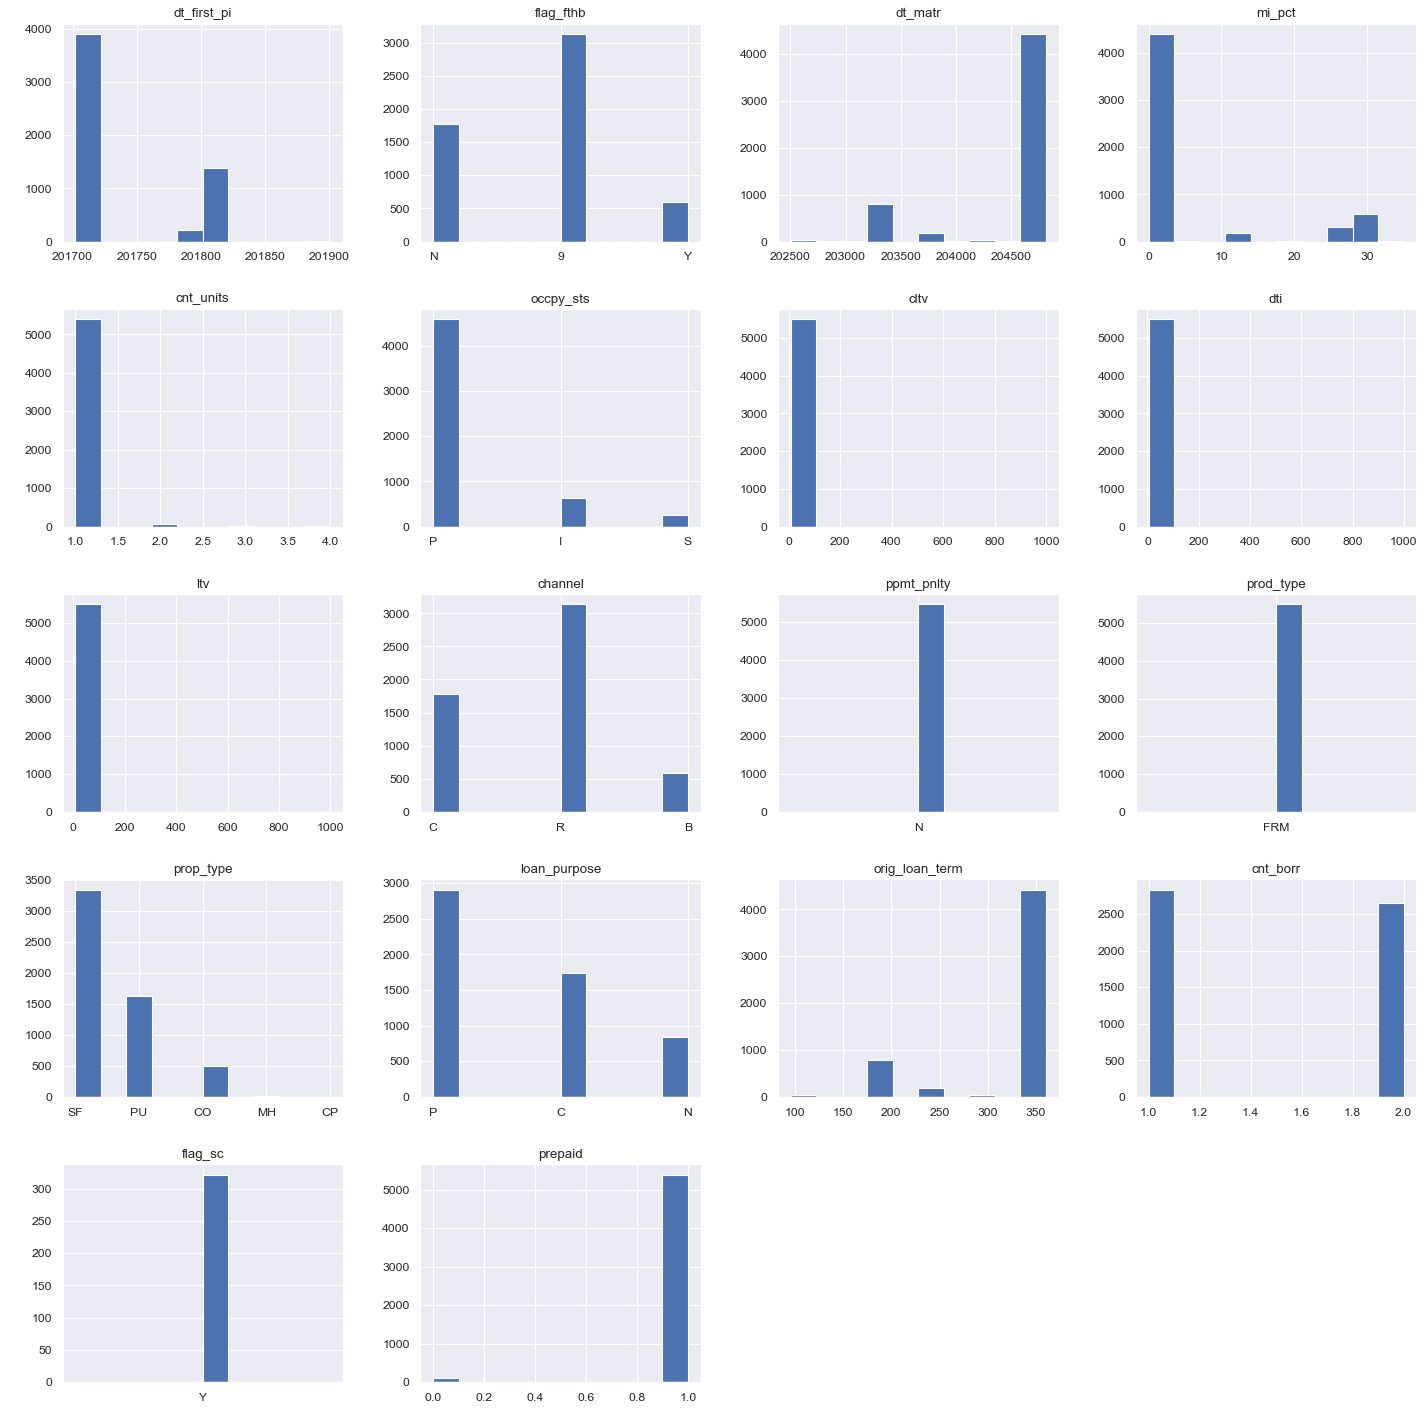

In [56]:
# Identifiers variables are: 'id_loan','cd_msa','zipcode'
# Long catgotical variables are: 'st', 'servicer_name', 'seller_name'
# Numerical variables are: 'fico', 'orig_upb', 'int_rt'
exclude_var = ['id_loan','cd_msa','zipcode','st', 'servicer_name', 'seller_name','fico', 'orig_upb', 'int_rt']

columns_to_plot = [col for col in X_train.columns if col not in exclude_var]

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(18, 18))
axes = axes.flatten()
fig.patch.set_facecolor('white')

for i, column in enumerate(columns_to_plot):
    X_train[column].hist(ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel(' ')

for j in range(len(columns_to_plot), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**identifiers** `id_loan` is an unique identifiers with no duplicates in this dataset. On the contrary, `zipcode` is not an unique identifier, observations are 5-digit area codes. Similarly, `cd_msa` are 5-digit codes of Metropolitan Statistical Area (MSA) regions, where the complete list of regions can be found [here](https://www2.census.gov/programs-surveys/cps/methodology/Geographic%20Coding%20-%20Metro%20Areas%20(since%20August%202005).pdf).


In [57]:
# Check for duplicates in 'id_loan' variable
duplicates = d[d.duplicated(subset=['id_loan'], keep=False)]

if not duplicates.empty:
    print("Duplicates found in 'id_loan' variable:")
    print(duplicates)
else:
    print("No duplicates found in 'id_loan' variable.")

d['zipcode_str'] = d['zipcode'].astype(str)

No duplicates found in 'id_loan' variable.


# Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model. You are strongly encouraged to explore many different modeling methods (e.g. linear regression, interaction terms, lasso, etc.) but you should not include a detailed narrative of all of these attempts. At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validating it.*

*For example if you considered a linear regression model, a polynomial regression, and a lasso model and ultimately settled on the linear regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the linear regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

*This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.*

*Finally, you should also provide comparison of your model with baseline model(s) on the test data but only briefly describe the baseline model(s) considered*

# Discussion & Conclusions

*In this section you should provide a general overview of your final model, its performance, and reliability. You should discuss what the implications of your model are in terms of the included features, predictive performance, and anything else you think is relevant.*

*This should be written with a target audience of a government official or charity directy, who is understands the pressing challenges associated with ageining and dementia but may only have university level mathematics (not necessarily postgraduate statistics or machine learning). Your goal should be to highlight to this audience how your model can useful. You should also mention potential limitations of your model.*

*Finally, you should include recommendations on potential lifestyle changes or governmental/societal interventions to reduce dementia risk.*

*Keep in mind that a negative result, i.e. a model that does not work well predictively, that is well explained and justified in terms of why it failed will likely receive higher marks than a model with strong predictive performance but with poor or incorrect explinations / justifications.*

# References

*Include references if any*

In [58]:
# Run the following to render to PDF
!jupyter nbconvert --to pdf project2.ipynb

[NbConvertApp] Converting notebook project2.ipynb to pdf
[NbConvertApp] Writing 448929 bytes to project2.pdf


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>